## 用逻辑回归进行信用卡欺诈检测

该项目涉及的知识点有：
LogisticRegression中的正则项的修改
                     阈值的修改
                     下采样和过采样的变化

###  一、项目背景：

背景描述：
信用卡支付为日常生活中常见的一种支付方式。当然，交易中也会存在着欺诈(信用卡被盗刷)行为。如果可以利用机器学习完成对欺诈情况的预测，有助于发卡机构实现反欺诈，保护持卡人的财产安全。

数据集可探索、研究的方向：
    可以从以下几个方面来探索数据集：
        识别信用卡盗刷；
        不平衡样本的处理方式
        尝试不同的重采样是如何影响模型的效果
        模型可以尝试Logistic回归、svm、决策树、XGBoost等进行预测
        模型评价标准：
            由于样本的不平衡性与不平衡率，推荐使用Area Under the Precision-Recall Curve (AUPRC)来衡量准确率。
            注意，对于非平衡样本的分类，不推荐使用混淆矩阵（Confusion matrix）进行准确率评估，因为是没有意义的。所以可以在平衡样本
            后使用混淆矩阵评估准确率。


### 二、理解数据

In [1]:
# 首先导入相关的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [24]:
# 导入数据并检查前5行
data = pd.read_csv('creditcardfraud.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


数据共有31列，包括Time、V1-V28、Amount，其中Class属于目标值，0代表正常，1代表欺诈数据，在特征数据中，Amount与其他特征数据的取值范围相比太大了，需要先对这一列进行标准化,因为计算机对于数值较大的值会误认为他的权重大，要把数据的大小尽量均衡，：下面通过条形图查看正常数据与欺诈数据的分布

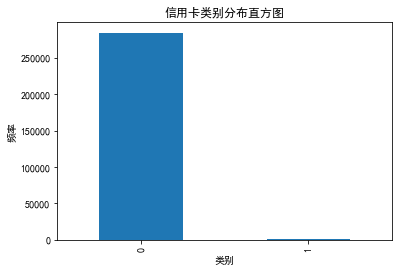

In [10]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

count_classes = pd.value_counts(data['Class'],sort=True).sort_index()
# count_classes = pd.value_counts(data['Class'])
# count_classes
count_classes.plot(kind='bar')
plt.title('信用卡类别分布直方图')
plt.xlabel('类别')
plt.ylabel('频率')
plt.show()

可以看到Class=0的数据大概有28W，欺诈数据Class=1极少，极度不均匀的分布状态。
通常有两种处理方法：
1、下采样（在0中取出部分数据，数量与1一致）
2、过采样（让1变得和0一样多）；

### 特征工程及划分训练集与训练集：

In [25]:
from sklearn.preprocessing import StandardScaler
# 导入标准库
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


查看数据已完成Amount列的标准化处理。
先采用下采样方法：

In [42]:
# 分别取出特征值和目标值
X = data.loc[:,data.columns != 'Class']
y = data.loc[:,data.columns == 'Class']

# 筛选出class为1的数据总数，并取得其索引值
number_records_fraud = len(data[data.Class==1])
fraud_indices = np.array(data[data.Class==1].index)

# 取出calss为0的索引值
normal_indices = data[data.Class==0].index

# 随机取出类型为0的X值，并转换成numpy 的 array格式
random_normal_indices = np.random.choice(normal_indices,number_records_fraud,replace=False)  # 无放回采样
# random_normal_indices
random_normal_indices = np.array(random_normal_indices)

#用concatenate将两组索引数据连接成新数据索引
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])
# under_sample_indices 

# 下采样数据集
under_sample_data = data.iloc[under_sample_indices,:]
# under_sample_data

# 切分下采样数据集的特征值与目标值
X_undersample = under_sample_data.loc[:,under_sample_data.columns != 'Class']
y_undersample = under_sample_data.loc[:,under_sample_data.columns == 'Class']

# 查看下采样数据集中特征值和目标值所占比重以及总数据
print('Class=0: ',len(under_sample_data[under_sample_data.Class==0])/len(under_sample_data))
print('Class=1: ',len(under_sample_data[under_sample_data.Class==1])/len(under_sample_data))
print('采样数据集： ', len(under_sample_data))


Class=0:  0.5
Class=1:  0.5
采样数据集：  984


In [43]:
# 将数据切分为训练集和测试集：
from sklearn.model_selection import train_test_split
# 对全部数据进行切分
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)
print('训练集数量： ', len(X_train))
print('测试集数量： ', len(X_test))
print('样本总数： ', len(X))

训练集数量：  199364
测试集数量：  85443
样本总数：  284807


In [45]:
# 对下采样数据进行切分
X_train_undersample,X_test_undersample,y_train_undersample,y_test_undersample = \
                        train_test_split(X_undersample,y_undersample,test_size = 0.3,random_state = 0)
print("下采样训练集数量: ", len(X_train_undersample))
print("下采样测试集数量: ", len(X_test_undersample))
print("下采样样本总数: ",len(X_undersample))

下采样训练集数量:  688
下采样测试集数量:  296
下采样样本总数:  984


模型效果评估：
由于我们是要尽可能将所有信用卡欺诈的数据找出来，所以有个很重要的衡量标准： 
召回率：Recall = TP/(TP+FN)
TP(true positives)：被正确分类的正例个数 
FN(false negatives)：被错误分类的负例个数 
FP(false positives)：被错误分类的负例个数 
TN(true negatives)：被正确分类的负例个数

### 建立模型：

In [46]:
# 导入机器学习库
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import confusion_matrix,recall_score,classification_report

In [106]:
def printing_Kfold_scores(x_train_data,y_train_data):
    fold = KFold(5,shuffle=True)    # 5折
    # 选择五折交叉验证
    # 选择不同的正则惩罚力度
    c_param_range = [0.01,0.1,1,10,100]
    results_table = pd.DataFrame(index=range(len(c_param_range)),columns=['C_parameter','Mean recall score'])
    results_table['C_parameter'] = c_param_range
    
    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    j = 0
    # 外层循环，调节循环参数
    for c_param in c_param_range:
        print('C parameter: ',c_param)
        recall_accs = []   # 因为是5折验证，该列表内部应该有5个值
        for iteration,indices in enumerate(fold.split(x_train_data), start=1):
            # 建立逻辑回归模型，逻辑回归中有很多惩罚参数，这里使用的是惩罚力度，指定惩罚方案为L1  
            lr = LogisticRegression(C = c_param, penalty = 'l1',solver='liblinear')
            
            # 使用训练集训练模型，并做交叉验证
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())
            
            # 在训练集中，交叉验证预测出的结果y,indices[0]是训练过的数据， indices[1] 是没有训练的数据
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)

            # 用预测的y值与真实的y值计算recall值，打印结果， indices[1] 真实的y值
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration ', iteration,': recall score = ', recall_acc)
            
        # 计算交叉验证结果得出的recall的平均值，并打印
        results_table.loc[j,'Mean recall score'] = np.mean(recall_accs)
        j += 1
        print('Mean recall score ', np.mean(recall_accs))
        print('*'*100)
    
    # idxmax() 表示最大值的id编号
    best_c = results_table.loc[results_table['Mean recall score'].astype(float).idxmax()]['C_parameter']
    
    # 最后，我们可以选择C参数之间的最优值
    print('从交叉验证中选择的最佳C参数模型是= ', best_c)
    return best_c    
                

In [107]:
best_c = printing_Kfold_scores(X_train_undersample,y_train_undersample)

C parameter:  0.01
Iteration  1 : recall score =  0.9736842105263158
Iteration  2 : recall score =  0.9841269841269841
Iteration  3 : recall score =  0.9594594594594594
Iteration  4 : recall score =  1.0
Iteration  5 : recall score =  0.9710144927536232
Mean recall score  0.9776570293732766
****************************************************************************************************
C parameter:  0.1
Iteration  1 : recall score =  0.835820895522388
Iteration  2 : recall score =  0.855072463768116
Iteration  3 : recall score =  0.8875
Iteration  4 : recall score =  0.9230769230769231
Iteration  5 : recall score =  0.96875
Mean recall score  0.8940440564734855
****************************************************************************************************
C parameter:  1
Iteration  1 : recall score =  0.9
Iteration  2 : recall score =  0.9558823529411765
Iteration  3 : recall score =  0.9076923076923077
Iteration  4 : recall score =  0.9230769230769231
Iteration  5 : recall sc

In [151]:
import itertools
def plot_confusion_matrix(cm,classes,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=0)
    plt.yticks(tick_marks,classes)
    
    thresh = cm.max() / 2.
    # itertools.product(list1, list2) 依次取出list1中的每1个元素，与list2中的每1个元素，组成元组
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],horizontalalignment='center',verticalalignment='center',fontsize=18,color='white'\
                 if cm[i,j]>thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
        

下采样数据集中的召回率:  0.9115646258503401


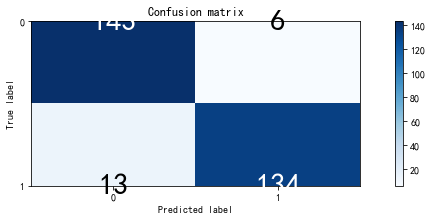

In [146]:
# 模型训练
lr = LogisticRegression(C=best_c,penalty='l1',solver='liblinear')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)

# 计算混淆矩阵
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
np.set_printoptions(precision=2)

print("下采样数据集中的召回率: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# 非归一化混淆矩阵
class_names = [0,1]
plt.figure(figsize=(10,3))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

In [147]:
# 混淆矩阵
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
cnf_matrix

array([[143,   6],
       [ 13, 134]], dtype=int64)

可以看到，131个真实的欺诈被模型找出来了，但是有7个被遗漏了，同时有18个正常数据被误判。下面用原始数据画出混淆矩阵图，看看结果：

原始数据的召回率为:  0.9251700680272109


<Figure size 432x288 with 0 Axes>

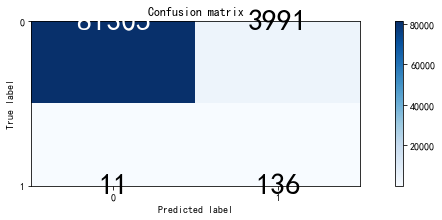

In [148]:
lr = LogisticRegression(C = best_c, penalty = 'l1',solver='liblinear')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)


# 计算混淆矩阵
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("原始数据的召回率为: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# 非归一化混淆矩阵
class_names = [0,1]
plt.figure()
plt.figure(figsize=(10,3))
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

在这里虽然召回率能达到91.8%，但是误判数量竟然达到了8581条，这无疑会对业务产生重大影响，如果一开没有对数据进行标准化，结果会不会好，下面进行验证：

In [136]:
best_c = printing_Kfold_scores(X_train,y_train)

C parameter:  0.01
Iteration  1 : recall score =  0.589041095890411
Iteration  2 : recall score =  0.5142857142857142
Iteration  3 : recall score =  0.582089552238806
Iteration  4 : recall score =  0.6351351351351351
Iteration  5 : recall score =  0.4426229508196721
Mean recall score  0.5526348896739477
****************************************************************************************************
C parameter:  0.1
Iteration  1 : recall score =  0.6857142857142857
Iteration  2 : recall score =  0.5540540540540541
Iteration  3 : recall score =  0.5512820512820513
Iteration  4 : recall score =  0.6666666666666666
Iteration  5 : recall score =  0.543859649122807
Mean recall score  0.6003153413679729
****************************************************************************************************
C parameter:  1
Iteration  1 : recall score =  0.640625
Iteration  2 : recall score =  0.6865671641791045
Iteration  3 : recall score =  0.6233766233766234
Iteration  4 : recall score =  0

###  上面我们使用的是Sigmoid函数中默认的阈值：0.5，如果我们自己指定阈值，效果会不会偏好，下面进行验证：

Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9931972789115646
Recall metric in the testing dataset:  0.9523809523809523
Recall metric in the testing dataset:  0.9251700680272109
Recall metric in the testing dataset:  0.8435374149659864
Recall metric in the testing dataset:  0.7755102040816326
Recall metric in the testing dataset:  0.5986394557823129


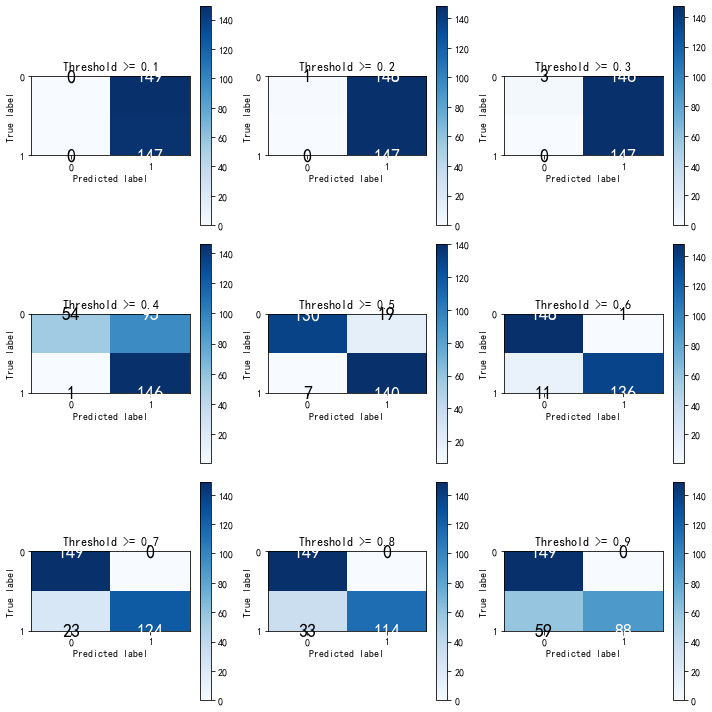

In [153]:
lr = LogisticRegression(C = 0.01, penalty = 'l1',solver='liblinear')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values) # 变成计算结果的概率值
# 指定阈值
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(10,10))
# 将预测的概率值与阈值进行对比
j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_undersample_proba[:,1] > i
    
    plt.subplot(3,3,j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test_undersample,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix, classes=class_names , title='Threshold >= %s'%i) 

当阈值为0.1-0.3时，召回率为1，说明太过严苛。随着阈值越来越大，模型的要求越来越宽松。这里需要根据实际业务实际需求，选定一个代价最低的模型

#### 下面采用过采用的方法，看看模型的效果：
过采样：
原理：从样本少的类别中随机抽样，再将抽样得来的样本添加到数据集中。
缺点：重复采样往往会导致严重的过拟合
主流过采样方法是通过某种方式人工合成一些少数类样本，从而达到类别平衡的目的，而这其中的鼻祖就是SMOTE。

In [155]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [ ]:
credit_cards=pd.read_csv('creditcard.csv')

columns=credit_cards.columns
# 最后一类是Class，简单地删除它，获得特征列
features_columns=columns.delete(len(columns)-1)

features=credit_cards[features_columns]
labels=credit_cards['Class']
features_train, features_test, labels_train, labels_test = train_test_split(features,  labels,  test_size=0.2, random_state=0)
oversampler=SMOTE(random_state=0)
os_features,os_labels=oversampler.fit_sample(features_train,labels_train)

In [ ]:
os_features = pd.DataFrame(os_features)
os_labels = pd.DataFrame(os_labels)
best_c = printing_Kfold_scores(os_features,os_labels)

In [ ]:
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(os_features,os_labels.values.ravel())
y_pred = lr.predict(features_test.values)

# 计算混淆矩阵
cnf_matrix = confusion_matrix(labels_test,y_pred)
np.set_printoptions(precision=2)

print("数据集的召回率为: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# 非归一化混淆矩阵
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

从上图可以明显看出，与下采样对比，误判比例明显小得多，也就是说，当我们用过采样策略，模型效果最好。